torch device: cuda:1
data acquired
Loading existing data...
(1454, 201, 6)
9.644129600493258


100%|██████████| 1454/1454 [00:32<00:00, 44.59it/s]


Unique crystal systems found: ['tetragonal', 'trigonal', 'cubic', 'monoclinic', 'hexagonal', 'triclinic', 'orthorhombic']
Splitting train/dev ...
Splitting valid/test ...
Number of training examples: 1160
Number of validation examples: 145
Number of testing examples: 149
Total number of examples: 1454


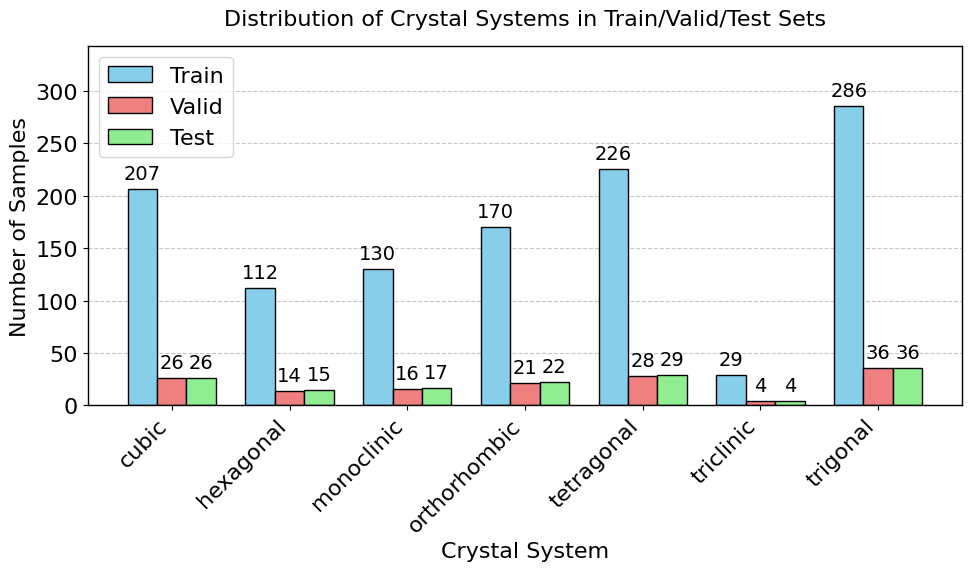

Dataset mean value, std value: tensor(0.0717) tensor(1.3736)
Dataset mean value (scaled): 0.0074, std value (scaled): 0.1424
Scaling factor (scale_data): 9.6441
Dataset mean value, std value: tensor(0.0709) tensor(1.3660)
Dataset mean value (scaled): 0.0074, std value (scaled): 0.1416
Scaling factor (scale_data): 9.6441
Dataset mean value, std value: tensor(0.0708) tensor(1.2962)
Dataset mean value (scaled): 0.0073, std value (scaled): 0.1344
Scaling factor (scale_data): 9.6441
Dataset mean value, std value: tensor(0.0716) tensor(1.3651)
Dataset mean value (scaled): 0.0074, std value (scaled): 0.1416
Scaling factor (scale_data): 9.6441
Testing dataloader_train:
Batch positions: torch.Size([72, 3])
Batch wigner_Ds type: <class 'list'>
Batch wigner_Ds length: 4
Batch wigner_Ds [0] length: 192
Batch wigner_Ds [1] length: 8
Batch wigner_Ds shapes: [[torch.Size([6, 6]), torch.Size([6, 6]), torch.Size([6, 6])], [torch.Size([6, 6]), torch.Size([6, 6]), torch.Size([6, 6])]]
n_train: 42.0282340

wandb: Currently logged in as: hsu-ting (hsu-ting-northeastern-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Predicting: 100%|██████████████████████████████| 23/23 [00:03<00:00,  6.14it/s]


In [1]:
import os
import sys

# Get the absolute path of the current notebook's directory
notebook_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(parent_dir)  # Add parent directory to sys.path
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter
import e3nn
from e3nn import o3
from typing import Dict, Union

# crystal structure data
from ase import Atom, Atoms
from ase.neighborlist import neighbor_list
from ase.visualize.plot import plot_atoms
palette = ['#43AA8B', '#F8961E', '#F94144']
sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# data pre-processing and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
from scipy.interpolate import interp1d
import math
import e3nn.o3 as o3
from e3nn.util.jit import compile_mode
from e3nn.io import CartesianTensor
from e3nn.o3 import wigner_D, so3_generators

# supress error log from font
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)
# utilities
import time
from mendeleev import element
from tqdm import tqdm
from utils.utils_data import (load_data, train_valid_test_split, plot_example, plot_predictions, weighted_mean, save_or_load_onehot, build_data, plot_spherical_harmonics_comparison, plot_cartesian_tensor_comparison, extract_and_average)
# from utils.utils_model_full_tensor import Network, visualize_layers, train, evaluate
from utils.utils_model_equivariant import Network, visualize_layers, train, evaluate

import wandb

from sklearn.metrics import r2_score, mean_squared_error

plt.rcParams["mathtext.fontset"] = "cm"

bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

# Create a colormap based on the number of unique symbols
datasets = ['g', 'y', 'r']
colors = dict(zip(datasets, palette))
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', [palette[k] for k in [0,2,1]])


# Check device
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print('torch device:' , device)


## load data
# data_file = '../dataset/openmx_data_20250319_152811.pkl'
data_file = '../dataset/symmetrized_permittivity.pkl'
df, species = load_data(data_file)
df = df.reset_index(drop=True)

print('data acquired')



energy_min = 0 #Unit of energy in eV
energy_max = 30 #Unit of energy in eV
nstep = 201 #Number of the energy points

new_x = np.linspace(energy_min, energy_max, nstep)
# Efficiently interpolate all matrices using list comprehension
def interpolate_matrix(matrix, omega):
    """Interpolates the full (3001, 3, 3) matrix along the energy axis."""
    interp = interp1d(omega, matrix, kind='linear', axis=0, fill_value=0, bounds_error=False)
    return interp(new_x)  # Shape: (201, 3, 3)


# Apply interpolation efficiently
df['real_Permittivity_Matrices_interp'] = [
    interpolate_matrix(row['real_symmetrized_permittivity'], row['omega']) for _, row in df.iterrows()
]

# Apply the custom function to create a new column
df['energies_interp'] = df.apply(lambda x: new_x, axis=1)

perm_matrices_tensor = torch.tensor(np.stack(df['real_Permittivity_Matrices_interp'].values), dtype=torch.float64, device=device)

# Transform Cartesian tensor to irreps
x = CartesianTensor("ij=ji")  # Symmetric rank-2 tensor
sph_coefs_tensor = x.from_cartesian(perm_matrices_tensor)  # Shape: (num_samples, 201, 6)

df['sph_coefs'] = list(sph_coefs_tensor.cpu().numpy())  # Move to CPU and store as list


## Processed atom feature
def process_atom(Z):
    """Process atomic properties for an element."""
    specie = Atom(Z)
    Z_mass = specie.mass
    Z_dipole = element(specie.symbol).dipole_polarizability or 67.0
    Z_radius = element(specie.symbol).covalent_radius_pyykko
    return specie.symbol, Z - 1, Z_mass, Z_dipole, Z_radius


type_onehot, mass_onehot, dipole_onehot, radius_onehot, type_encoding = save_or_load_onehot()

# Find the scaling value
tmp = np.array([df.iloc[i]['sph_coefs'] for i in range(len(df))])
print(tmp.shape)
scale_data = np.median(np.max(np.abs(tmp), axis=(1, 2)))
print(scale_data)
# scale_data = 1

from torch_geometric.data import Batch

def collate_fn(batch):
    batch_data = torch.utils.data.dataloader.default_collate([d for d in batch])
    wigner_D_list = [data.additional_attributes['wigner_D'] for data in batch]  # List of lists
    batch_data.additional_attributes = {'wigner_D': wigner_D_list}
    return batch_data
import pandas as pd
import torch
from torch_geometric.data import Data, Batch
from typing import Sequence, List, Tuple

class GraphDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        graphs: Sequence[Data],
        target: str,
        scale_data: float = None,  # Optional scaling factor
    ):
        self.df = df
        self.graphs = graphs  # List of Data objects from build_data
        self.target = target

        # Preprocess labels and wigner_D
        self.labels = [torch.tensor(itm).to(torch.float64) for itm in self.df[target]]
        self.wigner_D = [g.wigner_D for g in self.graphs]  # List of lists of (6, 6) tensors

        # Print dataset stats
        tmp_labels = torch.stack(self.labels)
        print('Dataset mean value, std value:', tmp_labels.view(-1).mean(), tmp_labels.view(-1).std())
        # Apply scaling to labels
        if scale_data is None:
            # If not provided, use the standard deviation of the labels as scale_data
            self.scale_data = std_val.item() if std_val > 0 else 1.0  # Avoid division by zero
        else:
            self.scale_data = scale_data
        self.labels = [label / self.scale_data for label in self.labels]
        # Print scaled stats
        tmp_scaled_labels = torch.stack(self.labels)
        scaled_mean = tmp_scaled_labels.view(-1).mean()
        scaled_std = tmp_scaled_labels.view(-1).std()
        print(f'Dataset mean value (scaled): {scaled_mean:.4f}, std value (scaled): {scaled_std:.4f}')
        print(f'Scaling factor (scale_data): {self.scale_data:.4f}')

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        g = self.graphs[idx]
        label = self.labels[idx]
        wigner_D = self.wigner_D[idx]  # List of (6, 6) tensors for this entry
        return g, wigner_D, label

    @staticmethod
    def collate(samples: List[Tuple[Data, list, torch.Tensor]]):
        graphs, wigner_Ds, labels = map(list, zip(*samples))
        for g in graphs:
            if hasattr(g, 'wigner_D'):
                del g.wigner_D
        batched_graph = Batch.from_data_list(graphs)  # Batch standard graph attributes
        batched_labels = torch.stack(labels)
        return batched_graph, wigner_Ds, batched_labels  # wigner_Ds remains a list of lists

    def get_scale_data(self):
            """Return the scaling factor for external use (e.g., prediction)."""
            return self.scale_data



r_max = 6. # cutoff radius
df['data'] = df.progress_apply(lambda x: build_data(x, 'sph_coefs', scale_data, type_onehot, mass_onehot, dipole_onehot, radius_onehot, type_encoding, r_max), axis=1)


run_time = time.strftime('%y%m%d', time.localtime())
# train/valid/test split
# idx_train, idx_valid, idx_test = train_valid_test_split(df, species, valid_size=.1, test_size=.1, plot=True)
idx_train, idx_valid, idx_test = train_valid_test_split(df, valid_size=.1, test_size=.1, plot=True)
#Save train loss values sets
np.savetxt('../model/idx_train_'+ run_time +'.txt', idx_train, fmt='%i', delimiter='\t')
np.savetxt('../model/idx_valid_'+ run_time +'.txt', idx_valid, fmt='%i', delimiter='\t')
np.savetxt('../model/idx_test_'+ run_time +'.txt', idx_test, fmt='%i', delimiter='\t')
# load train/valid/test indices
with open('../model/idx_train_'+run_time+'.txt', 'r') as f: idx_train = [int(i.split('\n')[0]) for i in f.readlines()]
with open('../model/idx_valid_'+run_time+'.txt', 'r') as f: idx_valid = [int(i.split('\n')[0]) for i in f.readlines()]
with open('../model/idx_test_'+run_time+'.txt', 'r') as f: idx_test = [int(i.split('\n')[0]) for i in f.readlines()]

# Build graphs for the entire dataset
graphs = [build_data(row, column='sph_coefs', scale_data=scale_data, type_onehot=type_onehot, 
                     mass_onehot=mass_onehot, dipole_onehot=dipole_onehot, 
                     radius_onehot=radius_onehot, type_encoding=type_encoding) 
          for _, row in df.iterrows()]

# Create datasets for train, valid, test splits with 'sph_coefs' as target
train_dataset = GraphDataset(df.iloc[idx_train], [graphs[i] for i in idx_train], target='sph_coefs',scale_data=scale_data)
valid_dataset = GraphDataset(df.iloc[idx_valid], [graphs[i] for i in idx_valid], target='sph_coefs',scale_data=scale_data)
test_dataset = GraphDataset(df.iloc[idx_test], [graphs[i] for i in idx_test], target='sph_coefs',scale_data=scale_data)
from torch.utils.data import DataLoader
# Define DataLoaders
batch_size = 4
dataloader_train = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=GraphDataset.collate,
    shuffle=True
)
dataloader_valid = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    collate_fn=GraphDataset.collate,
    shuffle=False
)
dataloader_test = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=GraphDataset.collate,
    shuffle=False
)


total_dataset = GraphDataset(df, graphs, target='sph_coefs', scale_data=scale_data)
total_dataloader =  DataLoader(
    total_dataset,
    batch_size=64,
    collate_fn=GraphDataset.collate,
    shuffle=False
)

# Test the DataLoaders
print("Testing dataloader_train:")
for batch in dataloader_train:
    batched_graph, wigner_Ds, labels = batch
    print("Batch positions:", batched_graph.pos.shape)
    print("Batch wigner_Ds type:", type(wigner_Ds))
    print("Batch wigner_Ds length:", len(wigner_Ds))
    print("Batch wigner_Ds [0] length:", len(wigner_Ds[0]))
    print("Batch wigner_Ds [1] length:", len(wigner_Ds[1]))
    print("Batch wigner_Ds shapes:", [[w.shape for w in wigner_D][:3] for wigner_D in wigner_Ds][:2])  # First 3 of first 2
    break

def get_neighbors(df, idx):
    n = []
    for entry in df.iloc[idx].itertuples():
        N = entry.data.pos.shape[0]
        for i in range(N):
            n.append(len((entry.data.edge_index[0] == i).nonzero()))
    return np.array(n)

n_train = get_neighbors(df, idx_train)
n_valid = get_neighbors(df, idx_valid)
n_test = get_neighbors(df, idx_test)
print("n_train:", n_train.mean())

## NN part
class MixingLinear(nn.Module):
    def __init__(self, in_feature, out_feature):
        super(MixingLinear, self).__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.weight = nn.Parameter(torch.Tensor(self.out_feature, self.in_feature))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=5**0.5)

    def forward(self, x):
        weight = torch.abs(self.weight)/(torch.sum(torch.abs(self.weight), dim=1, keepdim=True)+1e-10)
        return F.linear(x, weight)
class PeriodicNetwork(Network):
    def __init__(self, in_dim, em_dim, num_crystal_systems=7, **kwargs):            
        # override the `reduce_output` keyword to instead perform an averge over atom contributions    
        self.pool = False
        if kwargs['reduce_output'] == True:
            kwargs['reduce_output'] = False
            self.pool = True
            
        super().__init__(**kwargs)
        
        self.em_z = nn.Linear(in_dim, em_dim)    #Linear layer for atom type
        # self.em_x = nn.Linear(in_dim, em_dim)    #Linear layer for atom type

        self.em_mass = nn.Linear(in_dim, em_dim)    #Linear layer for atom mass
        self.em_dipole = nn.Linear(in_dim, em_dim)  #Linear layer for atom dipole polarizability
        self.em_radius = nn.Linear(in_dim, em_dim)  #Linear layer for atom covalent radius
        self.em_crystal_system = nn.Linear(num_crystal_systems, em_dim)  # Linear layer for crystal system
        self.em_mixing = MixingLinear(3, 1)            #Linear layer for mixing the atom features (mass, dipole, radius)

    def forward(self, data: Union[tg.data.Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        data.z = F.relu(self.em_z(data.z))
        # data.x = F.relu(self.em_x(data.x))
        
        data.x_mass = F.relu(self.em_mass(data.x_mass))
        data.x_dipole = F.relu(self.em_dipole(data.x_dipole))
        data.x_radius = F.relu(self.em_radius(data.x_radius))
        # crystal_system_embed = F.relu(self.em_crystal_system(data.crystal_system_onehot))  # Shape: (em_dim,)
        # num_nodes = data.x_mass.shape[0]
        # if hasattr(data, 'batch') and data.batch is not None:
        #     crystal_system_embed = crystal_system_embed[data.batch]  # Shape: (num_nodes, em_dim)
        # else:
        #     # Single graph case: repeat for all nodes
        #     crystal_system_embed = crystal_system_embed.squeeze(0).repeat(num_nodes, 1)  # Shape: (num_nodes, em_dim)    
            
        # tmp = torch.stack([data.x_mass, data.x_dipole, data.x_radius, crystal_system_embed], dim=0)  # Shape: (4, num_nodes, em_dim)        
        tmp = torch.stack([data.x_mass, data.x_dipole, data.x_radius], dim=0)  # Shape: (4, num_nodes, em_dim)        

        tmp2 = torch.permute(tmp, (1, 2, 0))                                       # permute the tensor to (N, em_dim, 3)
        data.x = torch.permute(self.em_mixing(tmp2),(2, 0, 1)).reshape(-1, em_dim) # reshape the tensor to (N, em_dim)
        # data.x = crystal_system_embed  # Test whether this makes a difference or not

        output = super().forward(data)
        # ReLu for last convolution will force output positive value, if output have negative value, it step should be neglected
        #output = torch.relu(output)
        
        # if pool_nodes was set to True, use scatter_mean to aggregate
        if self.pool == True:
            output = torch_scatter.scatter_mean(output, data.batch, dim=0)  # take mean over atoms per example
            # output = torch_scatter.scatter_add(output, data.batch, dim=0)  # take mean over atoms per example
            # output, _ = torch_scatter.scatter_max(output, data.batch, dim=0)  # max over atoms per examples
        # print(data.wigner_D.shape)
        # print(output.shape)
            
        return output

out_dim = len(df.iloc[0]['energies_interp'])      # about 200 points
em_dim = 64


use_batch_norm = False
dropout_prob=0.2

model = PeriodicNetwork(
    in_dim=118,
    em_dim=em_dim,
    irreps_in=str(em_dim)+"x0e",
    irreps_out=str(out_dim)+"x0e +" + str(out_dim) + "x2e",
    irreps_node_attr=str(em_dim)+"x0e",
    layers=2,
    mul=32,
    lmax=2,
    max_radius=r_max,
    num_neighbors=n_train.mean(),
    reduce_output=True,
    dropout_prob=dropout_prob,
    use_batch_norm = use_batch_norm
)
# visualize_layers(model)


model.to(device)


run_name = f'with_equivariant_model_re_{run_time}'

loss_fn = torch.nn.MSELoss(reduction='none')
loss_fn_mae = torch.nn.L1Loss(reduction='none')

loss_fn_eval = torch.nn.MSELoss()
loss_fn_mae_eval = torch.nn.L1Loss()

energy_grid = torch.linspace(energy_min, energy_max, steps=nstep).to(device)  # (201,)

use_weighting = False
# weighting_mode = "inverse_decay"
# weighting_mode = "exponential_decay"
wandb.init(
    project="Inference",  # Change this to your project name
    name=run_name,  # Unique identifier for this run
    config={
    }
)


# Predict on all data
model.load_state_dict(torch.load(f'../model/{run_name}_best.torch', map_location=device)['state'])
model.pool = True  # Enable pooling if applicable
model.to(device)
model.eval()

# Initialize DataFrame columns
df['mse_sph'] = 0.0
df['y_pred_sph'] = [None] * len(df)  # Pre-allocate with None
df['y_pred_cart'] = [None] * len(df)
df['mae_sph'] = 0.0
df['mse_cart'] = 0.0
df['mae_cart'] = 0.0


predictions = []
i0 = 0
bar_format = "{l_bar}{bar:30}{r_bar}"
out_dim = 201
irreps_dim = 6
with torch.no_grad():
    for i, batch in tqdm(enumerate(total_dataloader), total=len(total_dataloader), desc="Predicting", bar_format=bar_format):
        batched_graph, wigner_Ds, labels = batch  # Unpack consistent with train
        batched_graph = batched_graph.to(device)
        labels = labels.to(device)
        wigner_Ds = [[w.to(device) for w in wigner_D] for wigner_D in wigner_Ds]

        # Forward pass
        output = model(batched_graph)  # Shape: (batch_size, 1206), e.g., (16, 1206)
        batch_size = batched_graph.batch.max() + 1
        
        # Define irreps dimensions
        irreps_0e = model.irreps_out.count(o3.Irrep("0e"))  # e.g., 201
        irreps_2e = model.irreps_out.count(o3.Irrep("2e")) * 5  # e.g., 201 * 5 = 1005
        total_dim = irreps_0e + irreps_2e  # e.g., 201 + 1005 = 1206

        # Verify output shape
        expected_shape = (batch_size, total_dim)
        assert output.shape == expected_shape, f"Expected {expected_shape}, got {output.shape}"

        # Split into 0e and 2e components
        output_0e = output[:, :irreps_0e].view(batch_size, out_dim, 1)  # Shape: (batch_size, 201, 1)
        output_2e = output[:, irreps_0e:irreps_0e + irreps_2e].contiguous().view(batch_size, out_dim, 5)  # Shape: (batch_size, 201, 5)

        # Apply equivariant constraint pooling (consistent with train)
        invariant_output_0e = []
        invariant_output_2e = []
        assert len(wigner_Ds) == batch_size, f"wigner_Ds length {len(wigner_Ds)} != batch_size {batch_size}"
        
        for j, wigner_D in enumerate(wigner_Ds):
            # Process 0e component (scalar per omega point, shape: (201, 1))
            out_0e_j = output_0e[j]  # Shape: (201, 1)
            invariant_out_0e_j = out_0e_j  # 0e is invariant
            invariant_output_0e.append(invariant_out_0e_j)

            # Process 2e component (tensor, shape: (201, 5))
            out_2e_j = output_2e[j]  # Shape: (201, 5)
            wigner_D_tensor = torch.stack(wigner_D)  # Shape: (N_j, 6, 6)
            wigner_D_2e = wigner_D_tensor[:, 1:, 1:]  # Shape: (N_j, 5, 5)
            transformed_2e = torch.einsum("nij,wj->wni", wigner_D_2e, out_2e_j)  # Shape: (201, N_j, 5)
            invariant_out_2e_j = transformed_2e.mean(dim=1)  # Shape: (201, 5)
            invariant_output_2e.append(invariant_out_2e_j)

        # Stack invariant outputs
        invariant_output_0e = torch.stack(invariant_output_0e)  # Shape: (batch_size, 201, 1)
        invariant_output_2e = torch.stack(invariant_output_2e)  # Shape: (batch_size, 201, 5)

        # Combine predictions
        invariant_output = torch.cat([invariant_output_0e, invariant_output_2e], dim=2)  # Shape: (batch_size, 201, 6)

        # Split predictions
        output_0e = invariant_output[:, :, :irreps_0e]  # Shape: (batch_size, 201, 1)
        output_2e = invariant_output[:, :, irreps_0e:]  # Shape: (batch_size, 201, 5)

        # Ground truth
        y = labels.view(batch_size, out_dim, irreps_dim)  # Shape: (batch_size, 201, 6)
        y_0e = y[:, :, :irreps_0e]  # Shape: (batch_size, 201, 1)
        y_2e = y[:, :, irreps_0e:]  # Shape: (batch_size, 201, 5)

        # Compute MSE loss in spherical coordinates
        loss_0e = F.mse_loss(output_0e, y_0e)
        loss_2e = F.mse_loss(output_2e, y_2e)
        loss = loss_0e + loss_2e

        # Combine predictions
        combined_output = invariant_output  # Already in shape (batch_size, 201, 6)
        predictions.append(combined_output.cpu())

        # Store predictions and losses
        for batch_idx in range(y.shape[0]):
            df.loc[i0 + batch_idx, 'y_pred_sph'] = [combined_output[batch_idx].cpu().numpy()]
            # df.loc[i0 + batch_idx, 'y_pred_cart'] = [realsphvec2cart(combined_output[batch_idx].cpu().numpy())]
            df.loc[i0 + batch_idx, 'mse_sph'] = loss.cpu().numpy() * scale_data

        # Update batch index counter
        i0 += y.shape[0]
# predictions = [] 
# df['y_pred_sph'] = None
# i0 = 0
# with torch.no_grad():
#     for i, batch in tqdm(enumerate(total_dataloader), total=len(total_dataloader), bar_format=bar_format):
#         batched_graph, wigner_Ds, labels = batch  # Unpack consistent with train
#         batched_graph = batched_graph.to(device)
#         labels = labels.to(device)
#         # No need to move wigner_Ds since we're not using it

#         # Forward pass
#         output = model(batched_graph)  # Shape: (batch_size, 1206), e.g., (16, 1206)
#         batch_size = batched_graph.batch.max() + 1

#         # Define irreps dimensions
#         irreps_0e = model.irreps_out.count(o3.Irrep("0e"))  # e.g., 201
#         irreps_2e = model.irreps_out.count(o3.Irrep("2e")) * 5  # e.g., 201 * 5 = 1005
#         total_dim = irreps_0e + irreps_2e  # e.g., 201 + 1005 = 1206

#         # Verify output shape
#         expected_shape = (batch_size, total_dim)
#         assert output.shape == expected_shape, f"Expected {expected_shape}, got {output.shape}"

#         # Split into 0e and 2e components
#         output_0e = output[:, :irreps_0e].view(batch_size, out_dim, 1)  # Shape: (batch_size, 201, 1)
#         output_2e = output[:, irreps_0e:irreps_0e + irreps_2e].contiguous().view(batch_size, out_dim, 5)  # Shape: (batch_size, 201, 5)

#         # Ground truth (adjust labels to match prediction format)
#         y = labels.view(batch_size, out_dim, 6)  # Shape: (batch_size, 201, 6)
#         y_0e = y[:, :, :1]  # Shape: (batch_size, 201, 1)
#         y_2e = y[:, :, 1:]  # Shape: (batch_size, 201, 5)

#         loss_0e = F.mse_loss(output_0e, y_0e)   # MSE or other suitable loss
#         loss_2e = F.mse_loss(output_2e, y_2e)   # MSE or other suitable loss
#         loss = loss_0e + loss_2e
        
#         combined_output = torch.cat([output_0e, output_2e], dim=2)  # Shape: (batch_size, 201, 6)
#         predictions.append(combined_output.cpu())

#         # Store predictions and losses
#         for batch_idx in range(y.shape[0]):
#             df.loc[i0 + batch_idx, 'y_pred_sph'] = [combined_output[batch_idx].cpu().numpy()]
#             # df.loc[i0 + batch_idx, 'y_pred_cart'] = [realsphvec2cart(combined_output[batch_idx].cpu().numpy())]
#             df.loc[i0 + batch_idx, 'mse_sph'] = loss.cpu().numpy() * scale_data

#         # Update batch index counter
#         i0 += y.shape[0]

df['y_pred_sph'] = df['y_pred_sph'].map(lambda x: x[0]) * scale_data
column = 'real_Permittivity_Matrices_interp'

# Batch conversion to Cartesian coordinates
sph_tensors = torch.tensor(np.stack(df['y_pred_sph'].values))  # Shape: (num_samples, 201, 6)
cart_tensors = x.to_cartesian(sph_tensors)  # Assuming x.to_cartesian handles batch input
df['y_pred_cart'] = list(cart_tensors.numpy())

# Compute errors in Cartesian coordinates
cart_true = np.stack(df['real_Permittivity_Matrices_interp'].values)  # Shape: (num_samples, 201, 3, 3)
cart_pred = np.stack(df['y_pred_cart'].values)  # Shape: (num_samples, 201, 3, 3)

cart_true_tensor = torch.tensor(cart_true)
cart_pred_tensor = torch.tensor(cart_pred)

mse_cart = torch.mean((cart_pred_tensor - cart_true_tensor) ** 2, dim=(1, 2, 3)).numpy()
mae_cart = torch.mean(torch.abs(cart_pred_tensor - cart_true_tensor), dim=(1, 2, 3)).numpy()

df['mse_cart'] = mse_cart
df['mae_cart'] = mae_cart

# Compute errors in spherical coordinates
sph_true = np.stack(df['sph_coefs'].values)  # Shape: (num_samples, 201, 6)
sph_pred = np.stack(df['y_pred_sph'].values)  # Shape: (num_samples, 201, 6)

sph_true_tensor = torch.tensor(sph_true)
sph_pred_tensor = torch.tensor(sph_pred)

mae_sph = torch.mean(torch.abs(sph_pred_tensor - sph_true_tensor), dim=(1, 2)).numpy()
df['mae_sph'] = mae_sph

# Compute statistics
mse_sph_mean = df['mse_sph'].mean()
mse_sph_std = df['mse_sph'].std()
mse_cart_mean = df['mse_cart'].mean()
mse_cart_std = df['mse_cart'].std()

mae_sph_mean = df['mae_sph'].mean()
mae_sph_std = df['mae_sph'].std()
mae_cart_mean = df['mae_cart'].mean()
mae_cart_std = df['mae_cart'].std()
wandb.finish()


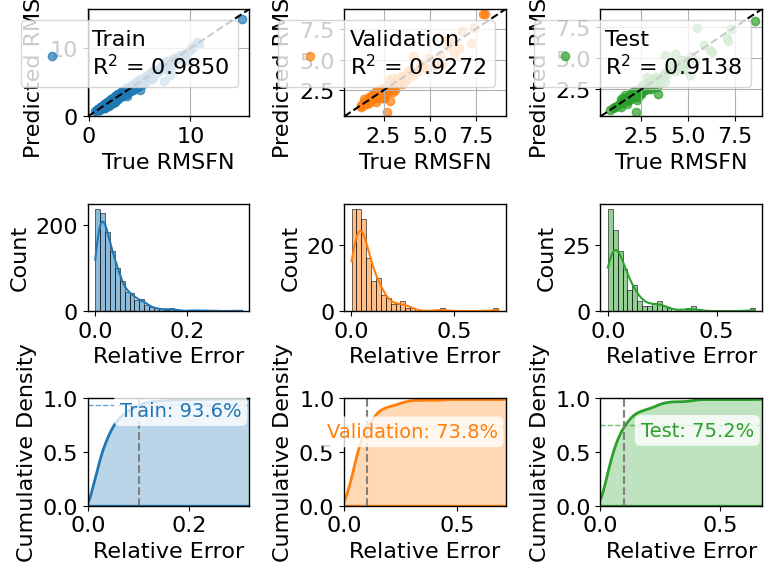

In [2]:
from sklearn.metrics import r2_score  # Import R² function
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df contains all data and idx_train, idx_valid, idx_test are defined
splits = {
    "Train": idx_train,
    "Validation": idx_valid,
    "Test": idx_test
}

# Dictionary to store results for each split
results = {split: {"target_RMS": [], "pred_RMS": [], "r2": None, "rel_error_RMS": [], "indices": []} for split in splits}

# Compute RMS Frobenius norms, R², and relative error for each split
for split_name, idx in splits.items():
    target_RMS_list = []
    pred_RMS_list = []
    rel_error_list = []
    indices_list = []
    
    for index, row in df.iloc[idx].iterrows():
        target = row["real_Permittivity_Matrices_interp"]  # Shape: (201, 3, 3)
        pred = row["y_pred_cart"]  # Shape: (201, 3, 3)

        # Compute Frobenius norm for each omega slice
        frobenius_target = [np.linalg.norm(target[i]) for i in range(target.shape[0])]
        frobenius_pred = [np.linalg.norm(pred[i]) for i in range(pred.shape[0])]

        # Compute RMS Frobenius Norm for target and pred
        target_RMS = np.sqrt(np.mean(np.square(frobenius_target)))
        pred_RMS = np.sqrt(np.mean(np.square(frobenius_pred)))

        # Compute relative error (normalized by target RMS)
        if target_RMS != 0:
            rel_error = np.abs(target_RMS - pred_RMS) / target_RMS
        else:
            rel_error = np.nan  # If target_RMS is zero, avoid division by zero

        # Store values
        target_RMS_list.append(target_RMS)
        pred_RMS_list.append(pred_RMS)
        rel_error_list.append(rel_error)
        indices_list.append(index)

    # Convert lists to NumPy arrays
    target_RMS_array = np.array(target_RMS_list)
    pred_RMS_array = np.array(pred_RMS_list)
    rel_error_array = np.array(rel_error_list)

    # Compute R² score
    r2 = r2_score(target_RMS_array, pred_RMS_array)
    
    # Store results
    results[split_name]["target_RMS"] = target_RMS_array
    results[split_name]["pred_RMS"] = pred_RMS_array
    results[split_name]["r2"] = r2
    results[split_name]["rel_error_RMS"] = rel_error_array
    results[split_name]["indices"] = indices_list

# Store rel_error in the DataFrame
for split_name, data in results.items():
    indices = data["indices"]
    rel_error_values = data["rel_error_RMS"]
    # Assign relative error values to the corresponding indices in df
    df.loc[indices, "rel_error_RMS"] = rel_error_values

# Create 3x3 panel plots (Scatter, Histogram, CDF)
fig, axes = plt.subplots(3, 3, figsize=(8, 6))

# Colors for each split
colors = {"Train": "#1f77b4", "Validation": "#ff7f0e", "Test": "#2ca02c"}

# First row: Scatter plots
for i, (split_name, data) in enumerate(results.items()):
    target_RMS_array = data["target_RMS"]
    pred_RMS_array = data["pred_RMS"]
    r2 = data["r2"]
    
    # Scatter plot
    axes[0, i].scatter(target_RMS_array, pred_RMS_array, alpha=0.7, color=colors[split_name], label=f"{split_name}\n$R^2$ = {r2:.4f}")
    axes[0, i].set_xlabel("True RMSFN")
    axes[0, i].set_ylabel("Predicted RMSFN")
    axes[0, i].grid(True)
    
    # Add y = x reference line
    min_val = min(min(target_RMS_array), min(pred_RMS_array))
    max_val = max(max(target_RMS_array), max(pred_RMS_array))
    
    buffer = (max_val - min_val) * 0.05  # 5% buffer
    min_val -= buffer
    max_val += buffer
    
    axes[0, i].set_xlim(min_val, max_val)
    axes[0, i].set_ylim(min_val, max_val)
    
    # Draw the y = x line within this range
    x_vals = np.linspace(min_val, max_val, 100)
    axes[0, i].plot(x_vals, x_vals, linestyle='--', color='black')
    axes[0, i].legend(fontsize=16)

# Second row: Histograms (plotting relative error)
for i, (split_name, data) in enumerate(results.items()):
    rel_error = data["rel_error_RMS"]
    
    # Histogram with KDE
    sns.histplot(rel_error, bins=30, kde=True, color=colors[split_name], edgecolor="black", ax=axes[1, i])
    axes[1, i].set_xlabel('Relative Error', fontsize=16)
    if i == 0:
        axes[1, i].set_ylabel("Count", fontsize=16)

# Third row: Separate CDF plots for each split
threshold = 0.1  # Threshold for relative error
perc_tr = np.mean(results["Train"]["rel_error_RMS"] < threshold) * 100
perc_va = np.mean(results["Validation"]["rel_error_RMS"] < threshold) * 100
perc_te = np.mean(results["Test"]["rel_error_RMS"] < threshold) * 100

y_offsets = [-0.05, -0.05, -0.05]  # Larger offsets to separate the text
for i, (split_name, data) in enumerate(results.items()):
    rel_error = data["rel_error_RMS"]
    xmax = max(rel_error)

    color = colors[split_name]
    perc = {"Train": perc_tr, "Validation": perc_va, "Test": perc_te}[split_name]

    # Plot cumulative density of relative errors
    sns.kdeplot(rel_error, fill=True, color=color, cumulative=True, label=split_name, alpha=0.3, linewidth=2, bw_adjust=0.5, ax=axes[2, i])

    # Add vertical and horizontal lines
    axes[2, i].axvline(x=threshold, color='gray', linestyle='--', linewidth=1.5)
    axes[2, i].axhline(y=perc/100, color=color, linestyle='--', linewidth=1, alpha=0.7)

    # Annotate the percentage with a background box
    x_annotate = xmax * 0.95  # Near the right edge
    y_pos = perc / 100 + y_offsets[i]  # Position at the percentage value
    axes[2, i].text(x_annotate, y_pos, f'{split_name}: {perc:.1f}%', color=color, fontsize=14, ha='right', va='center',
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.3'))

    # Customize the plot
    axes[2, i].set_xlim(0, xmax)
    axes[2, i].set_ylim(0, 1)
    axes[2, i].set_xlabel('Relative Error', fontsize=16)
    axes[2, i].set_ylabel('Cumulative Density', fontsize=16)

# Adjust layout and display
plt.tight_layout()
plt.show()


/tmp/ipykernel_1083478/565283329.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Train' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[idx, 'split'] = split_name
/tmp/ipykernel_1083478/565283329.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


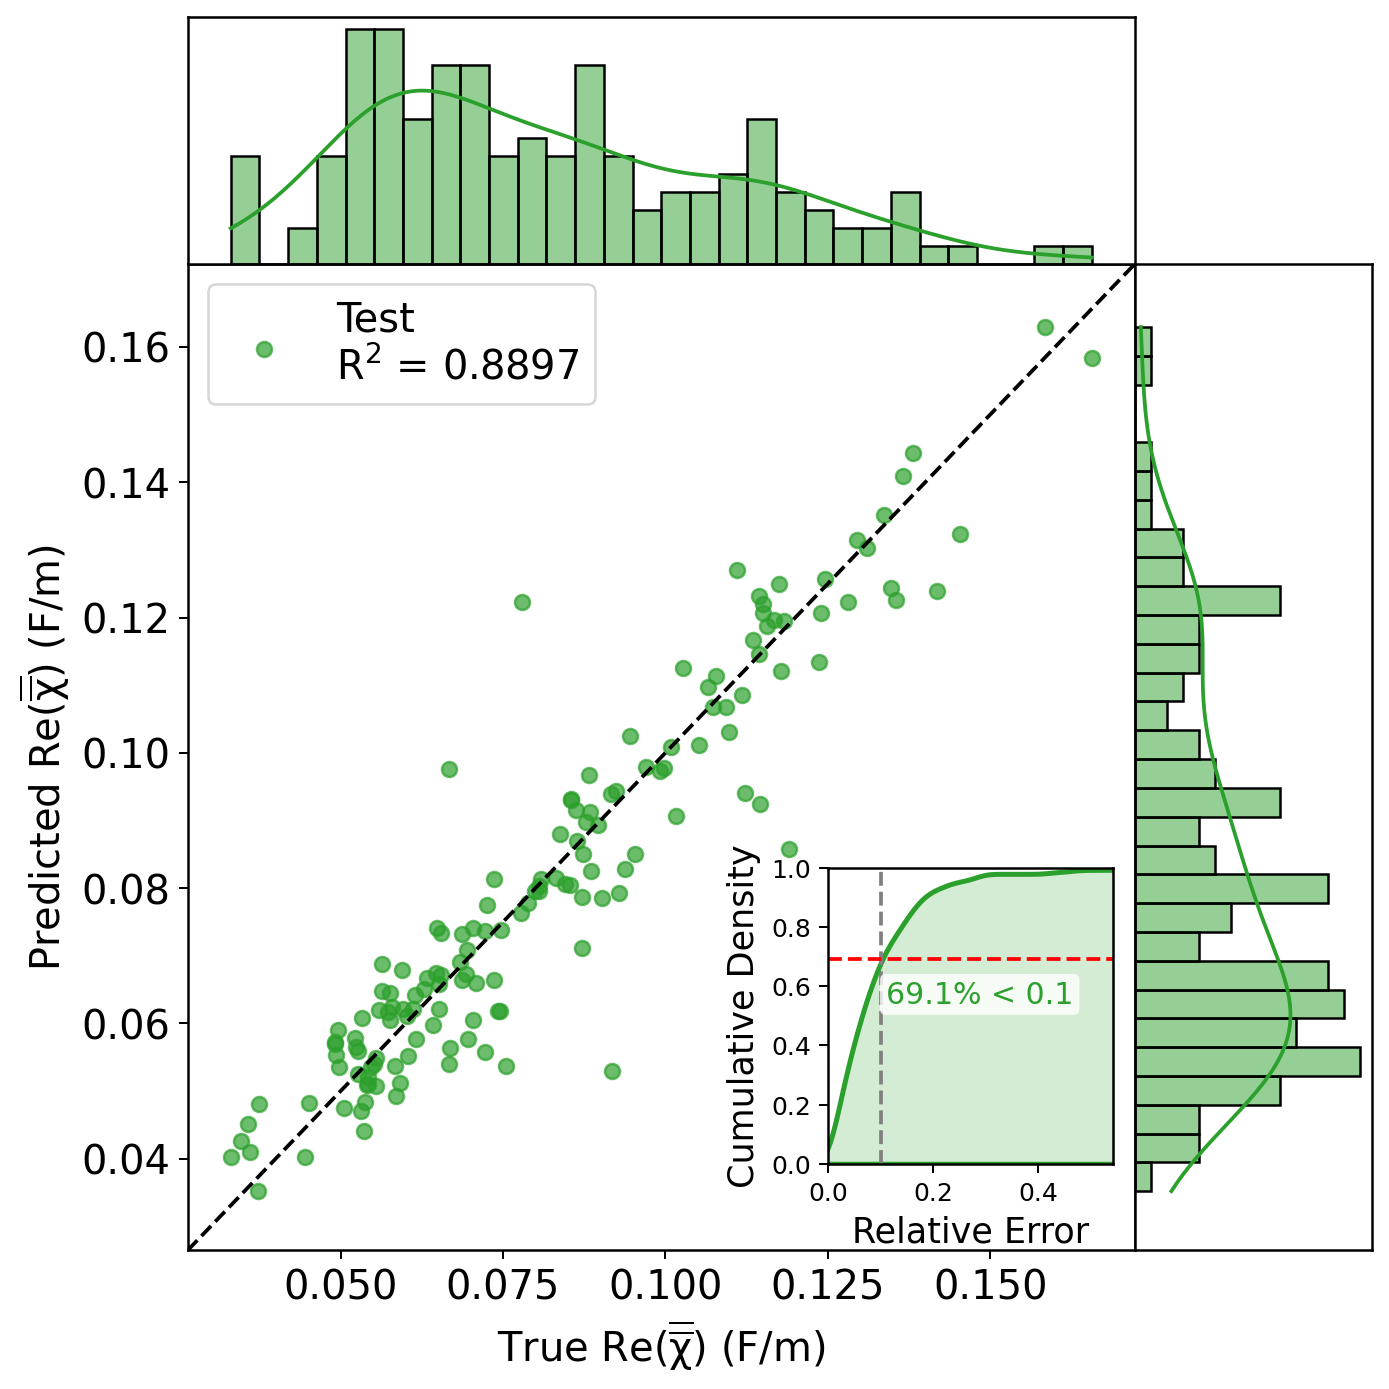

Train:
  R² = 0.9476
  Mean abs_diff = 0.0049
Validation:
  R² = 0.9142
  Mean abs_diff = 0.0060
Test:
  R² = 0.8897
  Mean abs_diff = 0.0065


In [3]:
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Assuming df contains all data and idx_train, idx_valid, idx_test are defined
splits = {
    "Train": idx_train,
    "Validation": idx_valid,
    "Test": idx_test
}

# Add a 'split' column to df to label each row with its split
df['split'] = np.nan
for split_name, idx in splits.items():
    df.loc[idx, 'split'] = split_name

# Compute the mean along dim=0 (energy dimension) for each [i,j] component
df['target_mean'] = df["real_Permittivity_Matrices_interp"].apply(
    lambda x: np.mean(x, axis=0)  # Mean over energy dimension (201)
)
df['pred_mean'] = df["y_pred_cart"].apply(
    lambda x: np.mean(x, axis=0)  # Mean over energy dimension (201)
)

# Compute the average over all components of the [3, 3] mean tensors
df['target_avg'] = df['target_mean'].apply(lambda x: np.mean(x))  # Average over all 9 components
df['pred_avg'] = df['pred_mean'].apply(lambda x: np.mean(x))      # Average over all 9 components

# Compute absolute difference between the averages
df['abs_diff_avg'] = np.abs(df['target_avg'] - df['pred_avg'])

# Extract Test set data
test_df = df[df['split'] == 'Test']
target_avg = test_df['target_avg'].values  # Shape: (num_test_samples,)
pred_avg = test_df['pred_avg'].values      # Shape: (num_test_samples,)
abs_diff_avg = test_df['abs_diff_avg'].values  # Shape: (num_test_samples,)

# Compute R² for the averaged values
r2 = r2_score(target_avg, pred_avg)

# Create a scatter plot with marginal histograms for the Test set
fig = plt.figure(figsize=(8, 8), dpi=180)
gs = fig.add_gridspec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], 
                      wspace=0.00, hspace=0.00)

# Define colors
colors = {"Train": "#1f77b4", "Validation": "#ff7f0e", "Test": "#2ca02c"}

# Main scatter plot (average over components)
ax_scatter = fig.add_subplot(gs[1, 0])
ax_scatter.scatter(target_avg, pred_avg, alpha=0.7, color=colors["Test"], 
                   label=f"Test\n$R^2$ = {r2:.4f}")
ax_scatter.set_xlabel(r"True $Re(\overline{\overline{\chi}}$) (F/m)", fontsize=16)
ax_scatter.set_ylabel(r"Predicted $Re(\overline{\overline{\chi}}$) (F/m)", fontsize=16)

# Add y = x reference line
min_val = min(min(target_avg), min(pred_avg))
max_val = max(max(target_avg), max(pred_avg))
buffer = (max_val - min_val) * 0.05
min_val -= buffer
max_val += buffer
ax_scatter.set_xlim(min_val, max_val)
ax_scatter.set_ylim(min_val, max_val)
x_vals = np.linspace(min_val, max_val, 100)
ax_scatter.plot(x_vals, x_vals, linestyle='--', color='black')
ax_scatter.legend(fontsize=16, loc='upper left', bbox_to_anchor=(0, 1.0))

# Top histogram (x-axis: True Avg)
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
sns.histplot(target_avg, bins=30, kde=True, color=colors["Test"], edgecolor="black", ax=ax_histx)
ax_histx.set_ylabel("")
ax_histx.set_xlabel("")
ax_histx.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax_histx.tick_params(axis='y', which='both', left=False, labelleft=False)

# Right histogram (y-axis: Predicted Avg)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_scatter)
sns.histplot(y=pred_avg, bins=30, kde=True, color=colors["Test"], edgecolor="black", ax=ax_histy)
ax_histy.set_xlabel("")
ax_histy.set_ylabel("")
ax_histy.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax_histy.tick_params(axis='y', which='both', left=False, labelleft=False)

# Add inset KDE plot for relative error (using CDF)
epsilon = 1e-8  # Small value to prevent division by zero
rel_error = np.abs((target_avg - pred_avg) / (np.abs(target_avg) + epsilon))

# Compute relative error KDE
inset_ax = inset_axes(ax_scatter, width="30%", height="30%", loc='lower right', 
                      bbox_to_anchor=(-0.005, 0.07, 1, 1), bbox_transform=ax_scatter.transAxes)
sns.kdeplot(rel_error, color=colors["Test"], ax=inset_ax, linewidth=2, bw_adjust=0.5, 
            fill=True, cumulative=True, alpha=0.2)
inset_ax.set_xlabel('Relative Error', fontsize=14)
inset_ax.set_ylabel('Cumulative Density', fontsize=14)
inset_ax.tick_params(axis='both', labelsize=10)
inset_ax.set_xlim(0, np.max(rel_error) * 0.95)
inset_ax.set_ylim(0, 1)

# Define threshold and compute percentage
threshold = 0.1  # Adjust based on rel_error range
perc_te = np.mean(rel_error < threshold) * 100
inset_ax.axvline(x=threshold, color='gray', linestyle='--', linewidth=1.5)
inset_ax.axhline(y=perc_te / 100, color='red', linestyle='--', linewidth=1.5)
inset_ax.text(threshold + 0.01, perc_te / 100 - 0.07, f'{perc_te:.1f}% < {threshold}', 
              color=colors["Test"], fontsize=12, ha='left', va='top', 
              bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'))

# Adjust layout
plt.tight_layout()
plt.show()

# Optional: Display summary statistics for each split
for split_name in splits:
    split_df = df[df['split'] == split_name]
    split_target_avg = split_df['target_avg'].values
    split_pred_avg = split_df['pred_avg'].values
    split_r2 = r2_score(split_target_avg, split_pred_avg)
    print(f"{split_name}:")
    print(f"  R² = {split_r2:.4f}")
    print(f"  Mean abs_diff = {split_df['abs_diff_avg'].mean():.4f}")


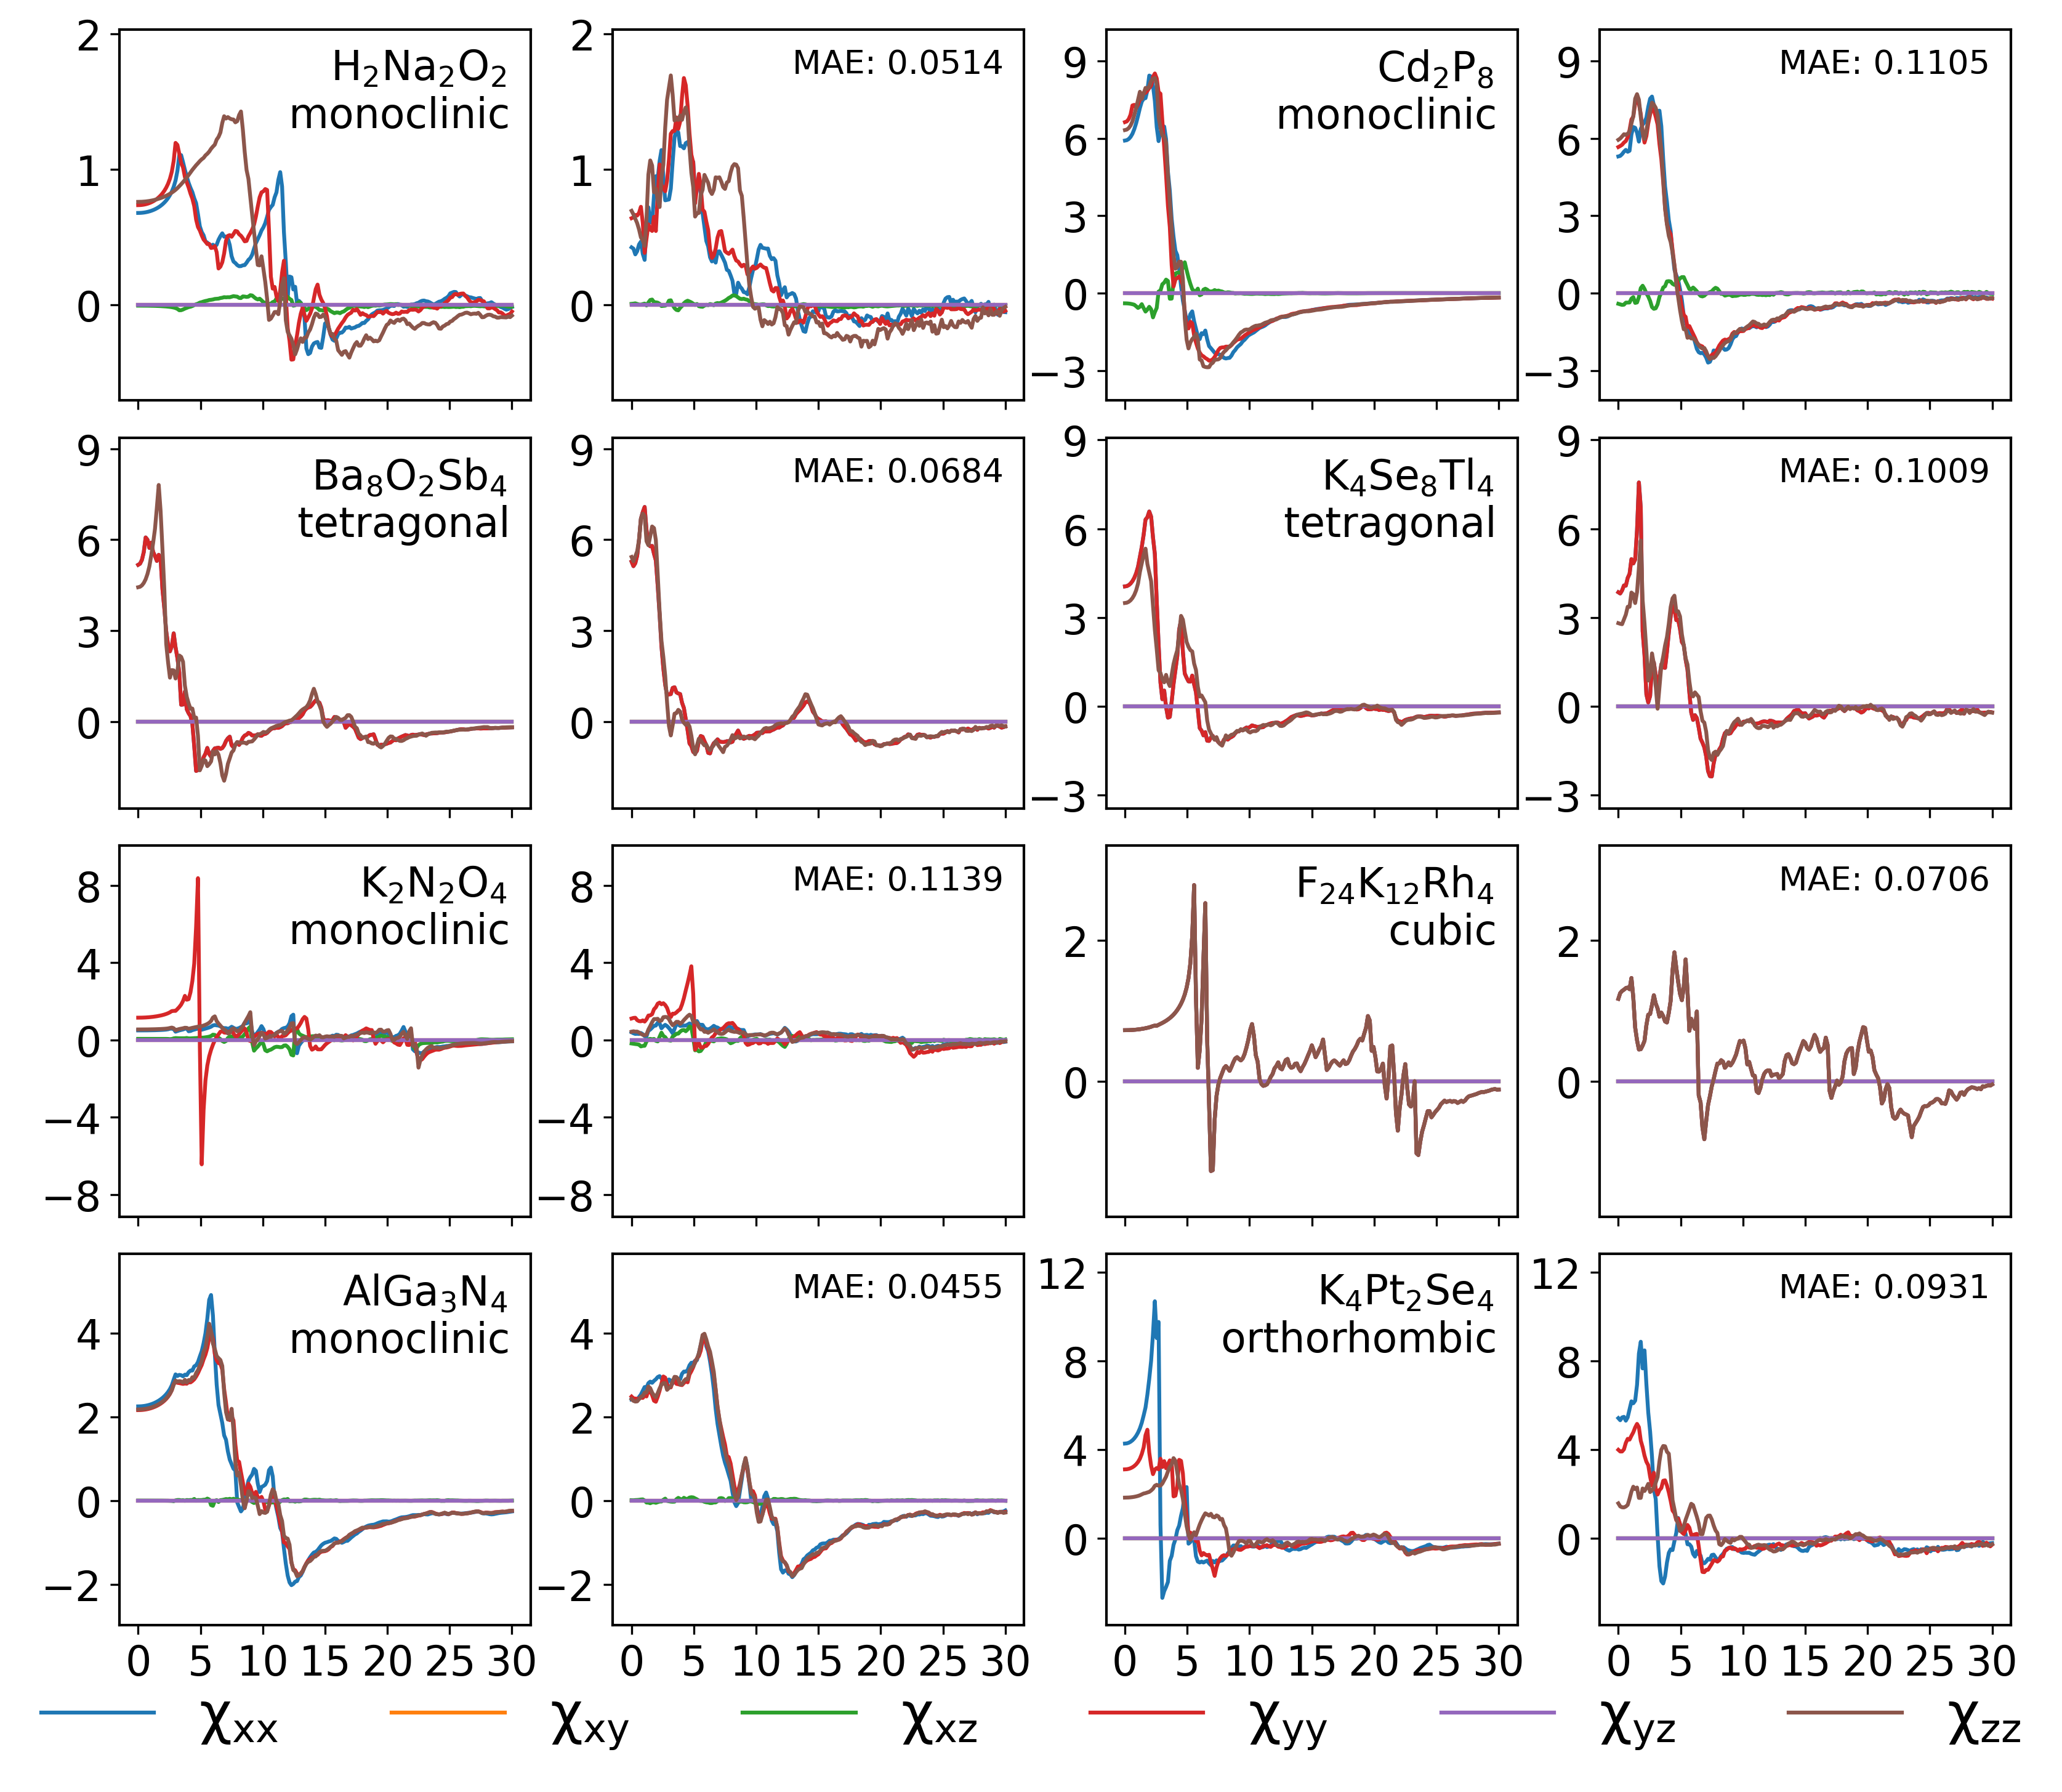

In [7]:
from matplotlib.ticker import MaxNLocator

def format_chemical_formula(formula):
    if not formula:
        return formula
    result = ''
    i = 0
    while i < len(formula):
        char = formula[i]
        if char.isalpha():
            element = char
            i += 1
            if i < len(formula) and formula[i].islower():
                element += formula[i]
                i += 1
            result += element
            number = ''
            while i < len(formula) and formula[i].isdigit():
                number += formula[i]
                i += 1
            if number:
                result += f'_{{{number}}}'
            if i < len(formula) and formula[i] == '^':
                i += 1
                superscript = ''
                while i < len(formula) and (formula[i].isdigit() or formula[i] in ['+', '-']):
                    superscript += formula[i]
                    i += 1
                if superscript:
                    result += f'^{{{superscript}}}'
        else:
            result += char
            i += 1
    return result

n_samples = 8 
def get_random_sample_indices(idx, n):
    """Returns `n` randomly selected unique indices from `idx`."""
    if len(idx) < n:
        n = len(idx)  # Ensure we don't exceed available samples
    return np.random.choice(idx, size=n, replace=False)

random_idx_test = get_random_sample_indices(idx_test, n_samples)


def plot_cartesian_tensor_comparison(df, idx, column_name, title_prefix="", n=3):
    """
    Plots multiple side-by-side line plots comparing predicted vs. real Cartesian tensors 
    in a more compact horizontal layout with minimal white space.

    Parameters:
    - df: Pandas DataFrame containing 'y_pred_cart' (predictions), 
          'real_Permittivity_Matrices_interp' (targets), and 'energies_interp'.
    - idx: List or array of indices to consider (e.g., idx_train, idx_test).
    - title_prefix: Prefix to be added to the plot title.
    - n: Number of samples to plot.
    """
    # Filter DataFrame based on provided indices
    ds = df.iloc[idx].reset_index(drop=True)

    # Define component labels
    xyz_list = ['x', 'y', 'z']
    tensor_components = [f"$\chi_{{{xyz_list[a]}{xyz_list[b]}}}$" for a in range(3) for b in range(a, 3)]

    # Define subplot grid layout
    n_rows = min(n, 4)  # Limit number of rows to at most 4
    n_cols = math.ceil(n / n_rows) * 2  # Ensures space for real & predicted pairs

    # Adjust figure size to reduce white space
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.8 * n_cols, 2.5 * n_rows), dpi=300, sharex=True)
    axes = axes.ravel()  # Flatten axes array for easy iteration

    handles, labels = [], []

    for i, sample_idx in enumerate(idx[:n]):  # Directly loop over provided idx
        material_id = ds.iloc[i]['mp_id']
        # mse_cart = ds.iloc[i]['mse_cart']
        mae_cart = ds.iloc[i]['mae_cart']
        
        crystal_system = ds.iloc[i]['crystal_system']
        formula = ds.iloc[i]['formula']
        omega = ds["energies_interp"].iloc[i]
        formatted_formula = format_chemical_formula(formula)
        real_permittivity = ds[column_name].iloc[i]  # (num_energies, 3, 3)
        pred_permittivity = ds["y_pred_cart"].iloc[i]  # (num_energies, 3, 3)
        
        y_min = min(real_permittivity.min(), pred_permittivity.min())
        y_max = max(real_permittivity.max(), pred_permittivity.max())
        
        # Left subplot: Real permittivity
        ax_real = axes[2 * i]  # Every even index is real data
        for idx, (a, b) in enumerate([(x, y) for x in range(3) for y in range(x, 3)]):
            h, = ax_real.plot(omega, real_permittivity[:, a, b], label=tensor_components[idx], linestyle='-')
            if i == 0:  # Collect legend items only from the first plot
                handles.append(h)
                labels.append(tensor_components[idx])
        if column_name =="real_Permittivity_Matrices_interp":
            ax_real.set_ylim((y_min-0.1) * 1.4, y_max * 1.2)
        else:
            ax_real.set_ylim((y_min-0.5) * 1.4, y_max * 1.2)
        ax_real.text(0.95, 0.95, f"${formatted_formula}$ \n {crystal_system}", 
             transform=ax_real.transAxes, fontsize=16, verticalalignment='top', 
             horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
        # ax_real.text(0.95, 0.95, r"${formatted_formula}$ \n {crystal_system}", transform=ax_real.transAxes, 
        #             fontsize=19, verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
        ax_real.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))

        # Right subplot: Predicted permittivity
        ax_pred = axes[2 * i + 1]  # Every odd index is predicted data
        for idx, (a, b) in enumerate([(x, y) for x in range(3) for y in range(x, 3)]):
            ax_pred.plot(omega, pred_permittivity[:, a, b], linestyle='-')
        if column_name =="real_Permittivity_Matrices_interp":
            ax_pred.set_ylim((y_min-0.1) * 1.4, y_max * 1.2)
        else:
            ax_pred.set_ylim((y_min-0.5) * 1.4, y_max * 1.2)
        # Format the text with fixed-width numbers and aligned labels
        # Use a monospace font and ensure consistent spacing
        text_str = (
            f"{'MAE:':<1} {mae_cart:>4.4f}\n"
        )

        # Add the text to the subplot
        ax_pred.text(
            0.95, 0.95,  # Position in axes coordinates (top-right)
            text_str,
            transform=ax_pred.transAxes,
            fontsize=13,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
        )
        ax_pred.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))
        
    # Remove x-labels from individual subplots
    for ax in axes:
        ax.set_xticks([])
    
    for ax in axes[-n_cols:]:  
        ax.set_xticks(np.linspace(omega.min(), omega.max(), 7))

    # Add a single, global x-axis label
    # fig.supxlabel("Photon energy (eV)", fontsize=24)
    # fig.supylabel(r"Im $\chi_{ij}(\omega) (F/m)$", fontsize=24)

    # Add a single legend outside the figure
    fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, 0.01), ncol=6, fontsize=22, frameon=False)
    
    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout
    plt.subplots_adjust(wspace=0.2, hspace=0.1)  

    os.makedirs("../pngs", exist_ok=True)
    save_path = f"../pngs/{title_prefix}_cart_spectra.png"
    fig.savefig(save_path, dpi=300)

    plt.show()

# random_idx_test = [ 435, 1118,  283, 1336,  436, 1418, 1201,   78]
# random_idx_test = [ 112, 1153, 1354,  1118,  238,   78,  959, 1303]
plot_cartesian_tensor_comparison(df, random_idx_test, column, title_prefix="testing_set", n=n_samples)


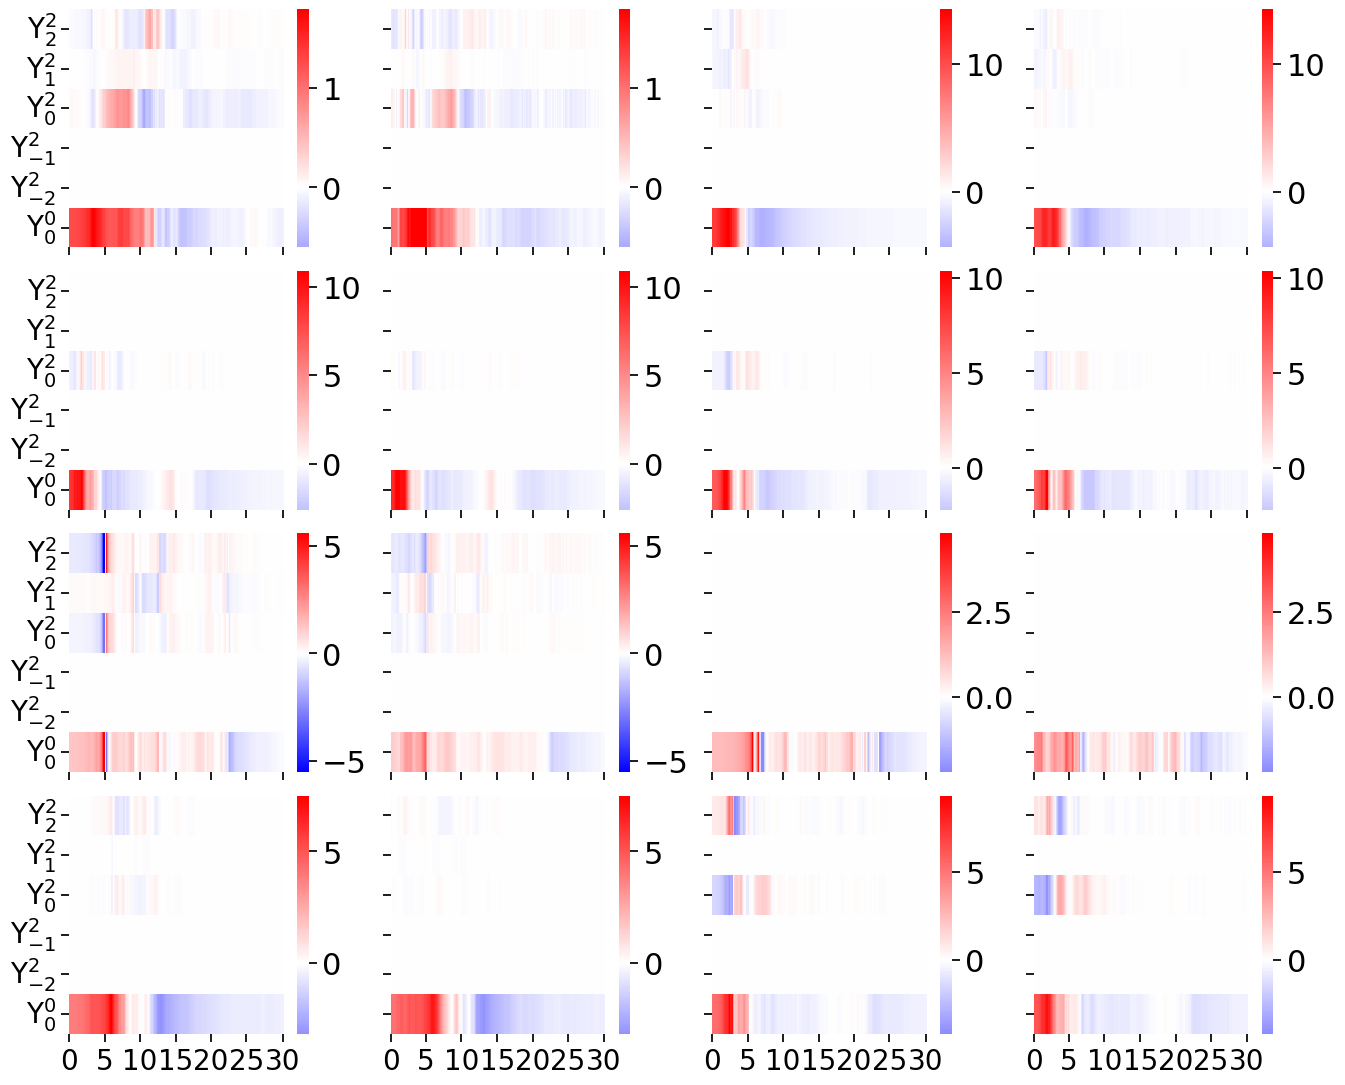

In [8]:
plot_spherical_harmonics_comparison(df, random_idx_test, column, title_prefix="testing_set", n=n_samples)


In [9]:
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor  # Import the converter
import numpy as np

sym_prec = 1e-2
tolerance = 1e-2
k = 0
N_samples = 40
sampled_df = df.sample(n=N_samples)  # Fix seed for reproducibility
all_masks = []
for index, row in df.iterrows():
    # Convert ASE Atoms object to pymatgen Structure
    ase_atoms = row.structure  # This is your ASE Atoms object
    pymatgen_structure = AseAtomsAdaptor.get_structure(ase_atoms)
    
    # Now use the pymatgen Structure with SpacegroupAnalyzer
    sga_primitive = SpacegroupAnalyzer(pymatgen_structure, symprec=sym_prec)
    refined_structure = sga_primitive.get_refined_structure()
    refined_sga = SpacegroupAnalyzer(refined_structure, symprec=sym_prec)
    symmetry_operations = refined_sga.get_symmetry_operations(cartesian=True)

    x = np.ones([3, 3])
    mask = np.zeros([3, 3])
    for op in symmetry_operations:
        R = op.rotation_matrix 
        mask += R @ x @ R.T
    mask /= len(symmetry_operations)
    all_masks.append(mask) 

    spectra = row["y_pred_cart"]  # Shape: (201, 3,3)
    # Check if each 3x3 tensor satisfies symmetry
    violations = []
    for i in range(spectra.shape[0]):  # Loop over omega
        S_matrix = spectra[i] # Reshape (9,) -> (3,3)
        # Check symmetry constraint
        residuals = S_matrix * (1 - mask)  # Keep only the disallowed values
        max_deviation = np.max(np.abs(residuals))  # Max deviation outside mask

        if max_deviation > tolerance:
            violations.append((i, max_deviation))
    sys = row["crystal_system"]
    # Print results
    if not violations:
        # print(f"Material {row['mp_id']} pass check")
        continue
    else:
        print(f"{index} Material {row['mp_id']} violates symmetry in {len(violations)} cases. {sys}")
        # for index, dev in violations[:5]:  # Print first few violations
        #     print(f"  - Row {index}: max deviation = {dev:.5e}")
df["symmetry_mask"] = all_masks
